In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 20 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

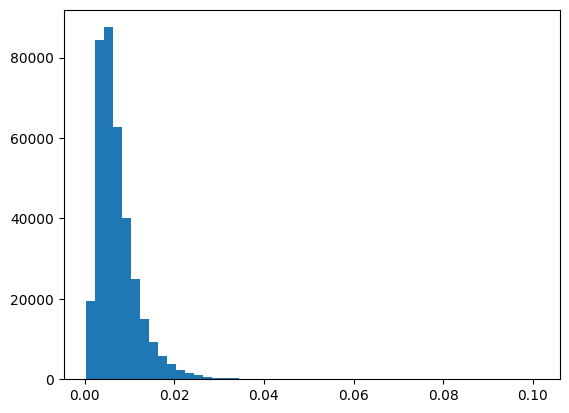

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 1
JEE0, JEI0, JIE0, JII0 = np.array([0.2, 0.16, 0.25, 0.13])
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.9
JEE = generate_matrix(NE, NE, gen(rng, JEE0, sEE), c=c) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen(rng, JEI0, sEI), c=c) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen(rng, JIE0, sIE), c=c) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen(rng, JII0, sII), c=c) / np.sqrt(NI)
plt.hist(JEE.flatten(), bins=50);

In [9]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [10]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
            JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI)

In [11]:
T_test = 5000 # test run
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
# For test purpose
sig1, sig2 = np.zeros((T_test, N_HVC)), np.zeros((T_test, NE))
sig1[T_test//2:] = peak_rate / N_HVC
sig2[:T_test//2] = rng.standard_normal(size=NE)
sig2[T_test//2:] = syl[0]
_ = net.sim(rE0, rI0, sig1, sig2, save_W_ts, T_test, dt, 1)
rE, rI, Ws, mean_HVC_input = _

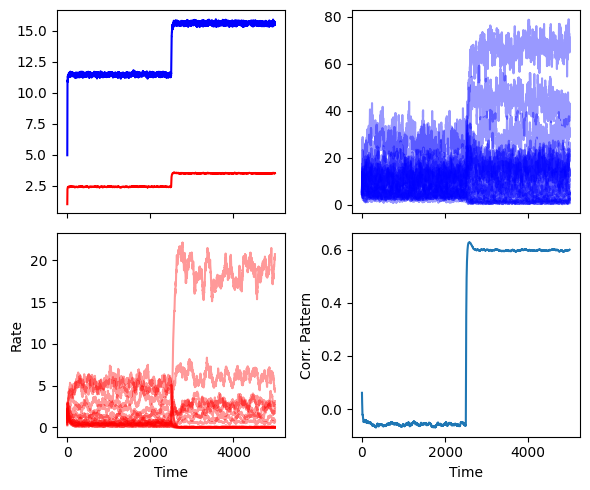

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5), sharex='all')
ax[0,0].plot(rE.mean(axis=1), color='r', label='E')
ax[0,0].plot(rI.mean(axis=1), color='b', label='I')
ax[0,1].plot(rI[:,:20], color='b', alpha=0.4)
ax[1,0].plot(rE[:,:20], color='r', alpha=0.4)
ax[1,0].set(xlabel='Time', ylabel='Rate')
ax[1,1].set(xlabel='Time', ylabel='Corr. Pattern')
ax[1,1].plot(correlation(rE, syl[0]))
fig.tight_layout()

[Text(0.5, 0, 'Rate change')]

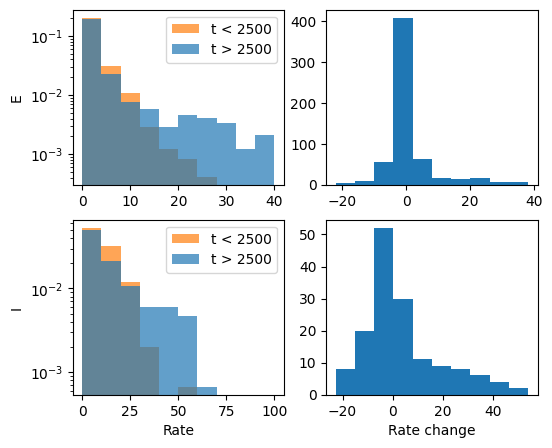

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
ax[0,0].hist([rE[T_test//2:].mean(axis=0), rE[:T_test//2].mean(axis=0)], 
             label=['t > %d' % (T_test//2), 't < %d' % (T_test//2)], alpha=0.7,
             log=True, bins=10, range=(0, rEmax), density=True, histtype='stepfilled')
ax[0,0].legend()
ax[0,1].hist(rE[T_test//2:].mean(axis=0) - rE[:T_test//2].mean(axis=0))
ax[1,0].hist([rI[T_test//2:].mean(axis=0), rI[:T_test//2].mean(axis=0)], 
             label=['t > %d' % (T_test//2), 't < %d' % (T_test//2)], alpha=0.7,
             log=True, bins=10, range=(0, rImax), density=True, histtype='stepfilled')
ax[1,0].legend()
ax[1,1].hist(rI[T_test//2:].mean(axis=0) - rI[:T_test//2].mean(axis=0))
ax[0,0].set(ylabel='E')
ax[1,0].set(xlabel='Rate', ylabel='I')
ax[1,1].set(xlabel='Rate change')

In [14]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 0.5) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [15]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-7e-2, w0_mean=w0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input = _

(<Figure size 400x600 with 4 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: ylabel='Mean exc. rate'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean inh. rate'>],
       dtype=object))

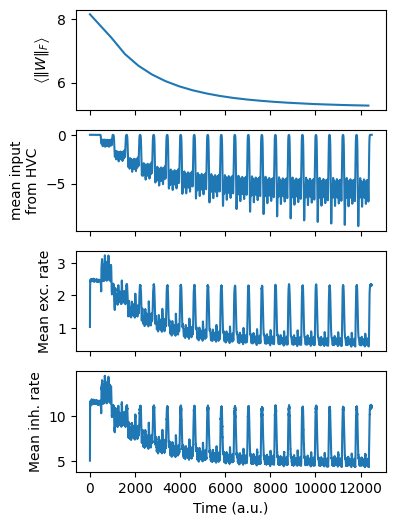

In [16]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts, rI)

In [17]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

(<Figure size 600x200 with 4 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}>,
        <Axes: title={'center': 'Rendition 10'}>,
        <Axes: title={'center': 'Rendition 20'}>], dtype=object))

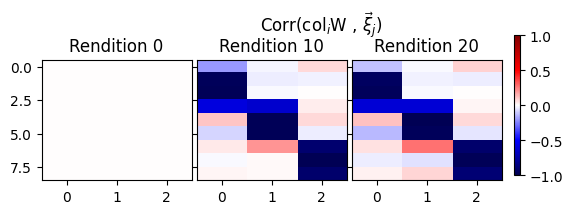

In [18]:
plot_wcol_corr(W_syl_corrs, (1, 3), (6, 2))

(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle |\\Delta W_{ij}|\\right\\rangle_i$'>,
        <Axes: ylabel='weight corr.\nabs. change'>,
        <Axes: ylabel='$\\left\\langle |r^E - r^E_0| \\right\\rangle$'>],
       dtype=object))

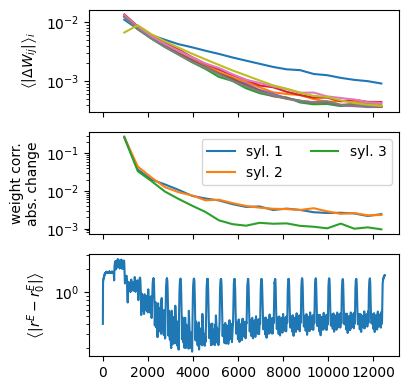

In [19]:
plot_train_converge(Ws, W_syl_corrs, save_W_ts, rE, 1)

(-6.664786127438509, 0.0)

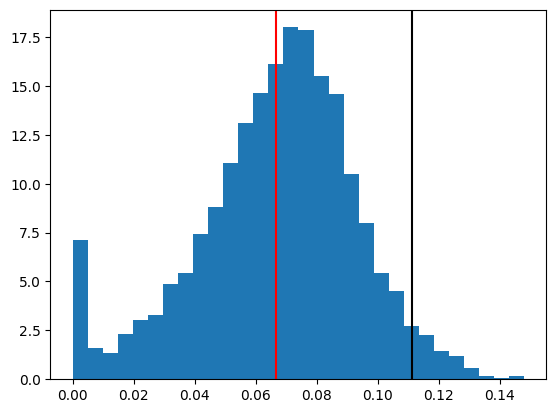

In [20]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')
(Ws[-1].mean() - w_inh) * peak_rate, wI * peak_rate / N_HVC

## Test Model with Unmatched Auditory Feedback

In [21]:
N_rend_test = 5
T_test = T_burn + T_rend * N_rend_test
t_test_start, t_test_end = tsyl_start[:,:N_rend_test], tsyl_end[:,:N_rend_test]
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH_ = generate_HVC(T_test, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
rH_null = np.zeros_like(rH_)
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
noise = 1

### Mismatch with completely independent patterns

In [22]:
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns (randomize)
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
syl_si = syl[idx_si]
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_si)
aud_sp = generate_discrete_aud(T_test, NE, t_test_start, t_test_end, syl_sp)
aud_si[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_sp[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))
aud_df = rng.normal(0, 1, size=aud_si.shape)

In [23]:
test_names = ('Singing\nctrl', 'Singing\nindex shuffled', 
              'Singing\npattern shuffled', 'Playback only', 'Singing\ndeafen')
# plasticity function is None and lr is 0 by default
test0 = net.sim(rE0, rI0, rH_, aud[:T_test], [], T_test, dt, noise)
test_si = net.sim(rE0, rI0, rH_, aud_si, [], T_test, dt, noise)
test_sp = net.sim(rE0, rI0, rH_, aud_sp, [], T_test, dt, noise)
test_pb = net.sim(rE0, rI0, rH_null, aud[:T_test], [], T_test, dt, noise)
test_df = net.sim(rE0, rI0, rH_, aud_df, [], T_test, dt, noise)
# just want rE and rI
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2]
test_pb, test_df = test_pb[:2], test_df[:2]
tests = (test0, test_si, test_sp, test_pb, test_df)

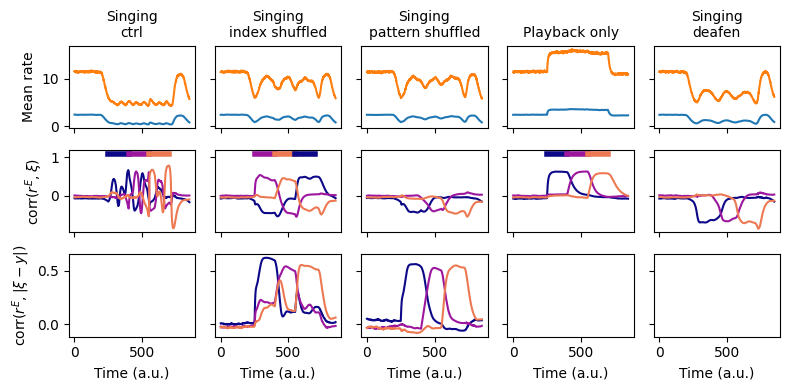

In [24]:
tests = (test0, test_si, test_sp, test_pb, test_df)
syl_tests = (syl, syl_si, syl_sp, syl, None)
cmap = colormaps.get_cmap('plasma')
fig, ax = plt.subplots(3, 5, sharey='row', sharex='all', figsize=(8, 4))
ti, tj = T_burn//2, T_burn + T_rend
for i, (test, syl_, l) in enumerate(zip(tests, syl_tests, test_names)):
    corr = correlation(test[0][ti:tj], syl, dim=2)
    ax[0,i].plot(test[0][ti:tj].mean(axis=1)[:])
    ax[0,i].plot(test[1][ti:tj].mean(axis=1)[:])
    ax[0,i].set_title(l, fontsize=10)
    ax[-1,i].set(xlabel='Time (a.u.)')
    for j in range(corr.shape[1]):
        ax[1,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))
    if i not in (0, 3, 4):
        corr = correlation(test[0][ti:tj], np.abs(syl - syl_), dim=2)
        for j in range(corr.shape[1]):
            ax[2,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))
            
for i, j in enumerate(idx_si):
    c1, c2 = cmap(i/len(idx_si)), cmap(j/len(idx_si))
    ts = np.array([tsyl_start[i,0], tsyl_end[i,0]]) - T_burn//2
    ax[1,0].plot(ts, [1.1, 1.1], color=c1, lw=4)
    ax[1,3].plot(ts, [1.1, 1.1], color=c1, lw=4)
    ax[1,1].plot(ts, [1.1, 1.1], color=c2, lw=4)
ax[0,0].set(ylabel='Mean rate')
ax[1,0].set(ylabel=r'corr$(r^E, \xi)$')
ax[2,0].set(ylabel=r'corr$(r^E, |\xi - y|)$')
fig.tight_layout()

In [25]:
# fig, ax = plt.subplots(3, sharex='all')
# i, j = 0, int(tsyl_end[2,0])
# ax[0].plot(rH[i:j], c='k')
# ax[1].plot(test0[0][i:j,:30], c='grey', alpha=0.5)
# ax[1].plot(test0[0][i:j,:].mean(axis=-1), c='r')
# ax[2].plot(test_sp[0][i:j,:30], c='grey', alpha=0.5)
# ax[2].plot(test_sp[0][i:j,:].mean(axis=-1), c='r')
# ax[0].set(ylabel='HVC rate')
# ax[1].set(ylabel='Response (Hz)')
# ax[2].set(xlabel='Time (a.u.)', ylabel='Response (Hz)')
# fig.tight_layout()

In [26]:
def temporal_sort(r, t0=0):
    # Negative or positive peaks
    when_ri_peak = np.argmax(np.abs(r[t0:]), axis=0)
    r_max = np.array([r[t0+t,i] for i, t in enumerate(when_ri_peak)])
    mask_pos, mask_neg = r_max > 0, r_max < 0
    n_pos, n_neg = mask_pos.sum(), mask_neg.sum()
    print(n_pos, n_neg)
    r_ret = np.zeros((r.shape[0], n_pos+n_neg))
    idx_pos = np.argsort(when_ri_peak[mask_pos])
    idx_neg = np.argsort(when_ri_peak[mask_neg])
    idx_all = np.hstack([np.where(mask_pos)[0][idx_pos], 
                         np.where(mask_neg)[0][idx_neg]])
    r_ret = r[:,idx_all]
    # r_ret[:,:n_pos] = r[:,mask_pos][:,idx_pos]
    # r_ret[:,n_pos:] = r[:,mask_neg][:,idx_neg]
    return r_ret, idx_all

192 408
50 100


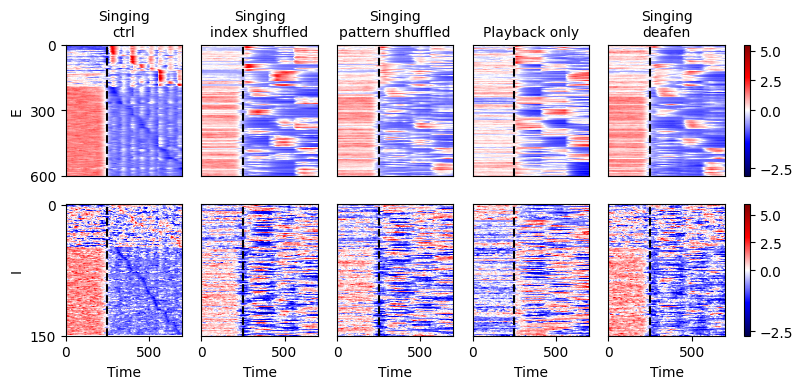

In [27]:
from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(2, len(tests)+1, figsize=(8, 4), 
                       width_ratios=[1]*len(tests)+[0.05])
ti, tj = T_burn//2, int(tsyl_end[2,0])
zs = []
for k, l in enumerate(tests):
    zs.append([normalize(l[0][ti:tj], axis=0), normalize(l[1][ti:tj], axis=0)])
z1min = min(list(map(lambda _: _[0].min(), zs)))
z1max = max(list(map(lambda _: _[0].max(), zs)))
z2min = min(list(map(lambda _: _[1].min(), zs)))
z2max = max(list(map(lambda _: _[1].max(), zs)))

idxE = temporal_sort(zs[0][0], t0=T_burn-ti)[1]
idxI = temporal_sort(zs[0][1], t0=T_burn-ti)[1]
for k, ((z1, z2), l) in enumerate(zip(zs, test_names)):
    # Uncomment the below to sort case-by-case
    # idxE = temporal_sort(z1, t0=T_burn-i)[1]
    # idxI = temporal_sort(z2, t0=T_burn-i)[1]
    im = ax[0,k].imshow(z1[:,idxE].T, aspect='auto', cmap='seismic', 
                        norm=TwoSlopeNorm(0, z1min, z1max))
    fig.colorbar(im, cax=ax[0,-1])
    im = ax[1,k].imshow(z2[:,idxI].T, aspect='auto', cmap='seismic', 
                        norm=TwoSlopeNorm(0, z2min, z2max))
    fig.colorbar(im, cax=ax[1,-1])
    ax[0,k].axvline(T_burn-ti, ls='--', c='k')
    ax[1,k].axvline(T_burn-ti, ls='--', c='k')
    ax[0,k].set_title(l, fontsize=10)
    ax[0,k].set(xticks=[], yticks=[])
    ax[1,k].set(xlabel='Time', yticks=[])
ax[0,0].set(ylabel='E', yticks=[0, 300, 600])
ax[1,0].set(ylabel='I', yticks=[0, 150])
fig.tight_layout()

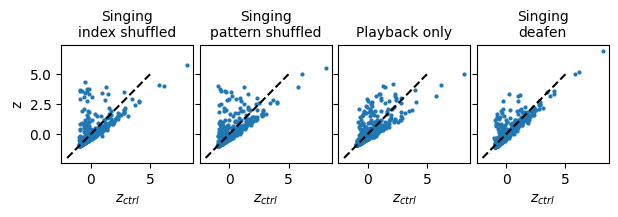

In [28]:
ti, tj = T_burn//2, int(tsyl_end[0,0])
zs = [normalize(t[0][ti:tj].mean(axis=0), axis=0) for t in tests]
fig, ax = plt.subplots(1, len(zs)-1, figsize=(6, 2), sharey='all')
for i, l in enumerate(test_names[1:]):
    ax[i].plot(zs[0], zs[i+1], 'o', ms=2)
    ax[i].plot([-2, 5], [-2, 5], c='k', ls='--')
    ax[i].set(xlabel=r'$z_{ctrl}$')
    ax[i].set_title(l, fontsize=10)
ax[0].set(ylabel='z')
fig.tight_layout(pad=0.1)

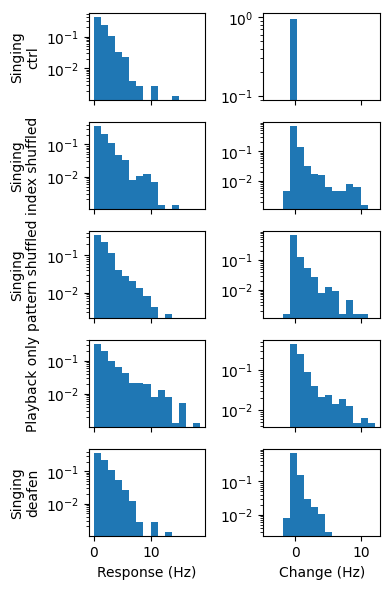

In [29]:
ti, tj = T_burn//2, int(tsyl_end[0,0])
ls = [t[0][ti:tj].mean(axis=0) for t in tests]
vmax = max(list(map(lambda _: _.max(), ls)))
fig, ax = plt.subplots(len(ls), 2, figsize=(4, 6), sharex='col')
for i, (l, k) in enumerate(zip(ls, test_names)):
    ax[i,0].hist(l, bins=15, range=(0, vmax), density=True, log=True)
    ax[i,0].set_ylabel(k, fontsize=10)
    ax[i,1].hist(l-ls[0], bins=15, range=(-4, 12), density=True, log=True)
ax[-1,0].set(xlabel='Response (Hz)')
ax[-1,1].set(xlabel='Change (Hz)')
fig.tight_layout()

### Mismatch with perturbed patterns

In [ ]:
perturb_type = 'SNR'
# perturb_type = 'ADD'
perturb_param = np.linspace(0, 1, num=11) 
tests, ovlps, corrs = [], [], []

for pm in perturb_param:
    eps = rng.standard_normal(size=syl.shape)
    syl_ = syl.copy()
    if perturb_type == 'SNR':
        mean_syl, std_syl = syl.mean(), syl.std()
        syl_ = (syl - mean_syl) / std_syl * (1 - pm) + np.sqrt(pm * (2 - pm)) * eps
        syl_ = syl_ * std_syl + mean_syl
    elif perturb_type == 'ADD':
        syl_ = syl + pm * eps
    else:
        raise NotImplementedError
    aud_ = generate_discrete_aud(T_test, NE, t_test_start.T.flatten(), 
                                 t_test_end.T.flatten(), np.tile(syl_, (N_rend_test, 1)))
    tests.append(net.sim(rE0, rI0, rH_, aud_, [], T_test, dt, noise))
    ovlps.append(tests[-1][-0] @ syl.T)
    corrs.append(correlation(tests[-1][0], syl, dim=2))

In [ ]:
fig, ax = plt.subplots(1, sharey='all', sharex='all', figsize=(4, 3))
# for i in range(ax.shape[1]):
#     ax[-1,i].set(xlabel='Time (a.u.)')
cmap = colormaps.get_cmap('viridis')
for i, (pm, test) in enumerate(zip(perturb_param, tests)):
    ax.plot(test[0][T_burn:T_burn+T_rend].mean(axis=1), c=cmap(i/len(perturb_param)))
    
ax.set(xlabel='Time (a.u.)', ylabel='Mean rate')
fig.tight_layout()

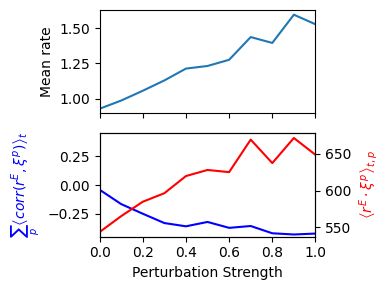

In [32]:
fig, ax = plt.subplots(2, sharex='all', figsize=(4, 3))
ax = [*ax, ax[1].twinx()]
ax[0].plot(perturb_param, list(map(lambda x: x[0].mean(), tests)))
ax[1].plot(perturb_param, list(map(lambda x: x.sum(axis=1).mean(), corrs)), 
           color='b', label='Corr.')
ax[2].plot(perturb_param, list(map(lambda x: x.mean(), ovlps)), 
           color='r', label='Overlap')
ax[0].set(ylabel='Mean rate')
_ = np.abs(ax[1].get_ylim()).max()
ax[1].set(xlabel='Perturbation Strength', xlim=perturb_param[[0,-1]], ylim=[-_, _])
ax[1].set_ylabel(r'$\sum_p\left\langle corr(r^E, \xi^p)\right\rangle_t$', c='b')
ax[2].set_ylabel(r'$\left\langle r^E \cdot \xi^p\right\rangle_{t,p}$', c='r')
fig.tight_layout()